In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Đọc dữ liệu
df = pd.read_csv("household_power_consumption.csv", sep=',')
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S")

# Ép kiểu số
cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.set_index('datetime', inplace=True)
df = df.dropna()

In [4]:
# Resample để giảm độ phức tạp: lấy trung bình mỗi 10 phút
df_sample = df[[
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]].resample('10min').mean().dropna().iloc[:500]

# Biến đầu vào là phút kể từ epoch
X = (df_sample.index.astype(np.int64) // 10**9 // 60).values.reshape(-1, 1)
y = df_sample['Global_active_power'].values

# Chuẩn hóa đầu ra
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

In [5]:
# Định nghĩa Gaussian Process với kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1)

# Huấn luyện
gp.fit(X, y_scaled)

# Dự đoán
y_pred_scaled, sigma = gp.predict(X, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

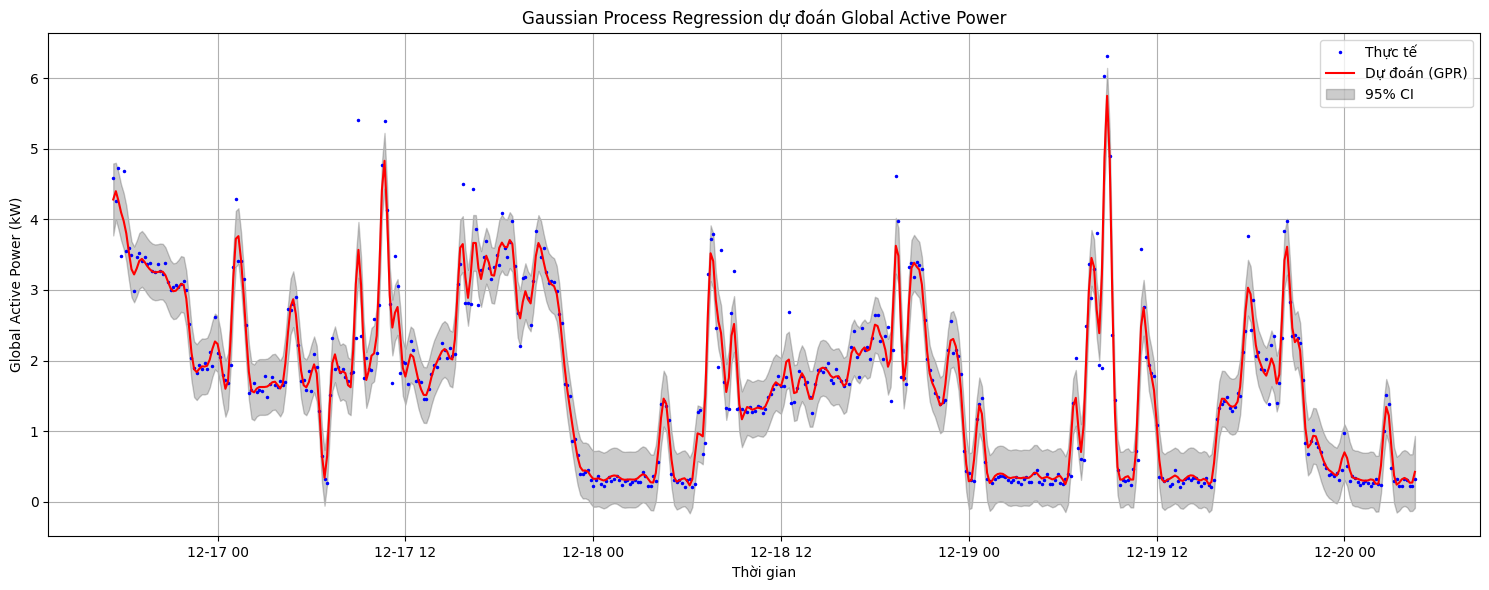

In [6]:
# Vẽ kết quả
plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, y, 'b.', markersize=3, label='Thực tế')
plt.plot(df_sample.index, y_pred, 'r-', label='Dự đoán (GPR)')
plt.fill_between(df_sample.index,
                 y_pred - 1.96 * sigma,
                 y_pred + 1.96 * sigma,
                alpha=0.2, color='k', label='95% CI')
plt.xlabel('Thời gian')
plt.ylabel('Global Active Power (kW)')
plt.title('Gaussian Process Regression dự đoán Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()